# Exercises:

file name: `clustering_anomaly_detection.py` or `clustering_anomaly_detection.ipynb`

### Clustering - DBSCAN

### 1. Use DBSCAN to detect anomalies in other products from the `customers` dataset. The database name is `grocery_db`.

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the `curriculum_logs` database.

### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the <a href="https://ds.codeup.com/clustering/explore/#exercises">clustering evaluation exercises</a> (single unit properties with a logerror).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import itertools
import env

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

## Grocery databse:

In [2]:
# acquiring data from MySQL serves
url = env.get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Step 1: Select variables you want to cluster

In [3]:
#creating new dataframe with features selected
x=df[['Detergents_Paper','Frozen','Delicassen']]
x.head()

,Detergents_Paper,Frozen,Delicassen
customer_id,,,
0,2674,214,1338
1,3293,1762,1776
2,3516,2405,7844
3,507,6404,1788
4,1777,3915,5185


## Step 2: Convert to array & dtype float

In [4]:
#converting features into floats and arrays
np_array = x.values.astype('float32',copy=False)

## Step 3: Scale to standard normal

In [5]:
# MAKE the scaler
mms=MinMaxScaler()
# FIT/transform the scaler
x_scaled=mms.fit_transform(np_array)

x_scaled

array([[0.0654272 , 0.0031063 , 0.02784731],
       [0.08058985, 0.02854842, 0.03698373],
       [0.08605233, 0.03911643, 0.16355862],
       ...,
       [0.36346266, 0.00677142, 0.03888194],
       [0.00404174, 0.01664914, 0.04426366],
       [0.01161082, 0.00065742, 0.00102211]], dtype=float32)

In [6]:
# adding scaled data into the original datagrame
scaled_columns = ["Scaled_"+ column for column in x.columns]

In [7]:
# creating a copy of the original data frame
original_df = df.copy()

In [8]:
scaled_df = pd.DataFrame(x_scaled,columns=scaled_columns)

In [9]:
#merge scale data and dropping Key_0
df = df.merge(scaled_df,on=df.index)
df = df.drop(columns=['key_0'])

## Step 4: Create DBSCAN and fit

In [10]:
# Make the object
dbsc = DBSCAN(eps=.1,min_samples=20)

# Fit the object
dbsc.fit(x_scaled)

DBSCAN(eps=0.1, min_samples=20)

## Step 5: Add labels back to original dataframe

In [11]:
# Assign the cluster labels
df['clusters_labels'] = dbsc.labels_

In [12]:
# new df viz
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Detergents_Paper,Scaled_Frozen,Scaled_Delicassen,clusters_labels
0,2,3,12669,9656,7561,214,2674,1338,0.065427,0.003106,0.027847,0
1,2,3,7057,9810,9568,1762,3293,1776,0.080590,0.028548,0.036984,0
2,2,3,6353,8808,7684,2405,3516,7844,0.086052,0.039116,0.163559,0
3,1,3,13265,1196,4221,6404,507,1788,0.012346,0.104842,0.037234,0
4,2,3,22615,5410,7198,3915,1777,5185,0.043455,0.063934,0.108093,0


## Step 7: Explore

In [13]:
# value counts of clusters and anomalies
df.clusters_labels.value_counts()

 0    423
-1     17
Name: clusters_labels, dtype: int64

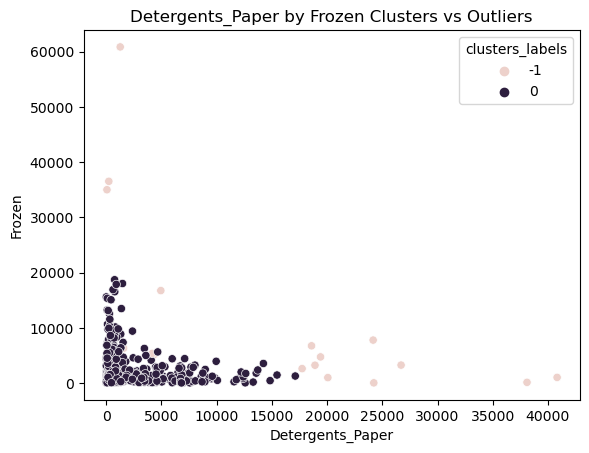

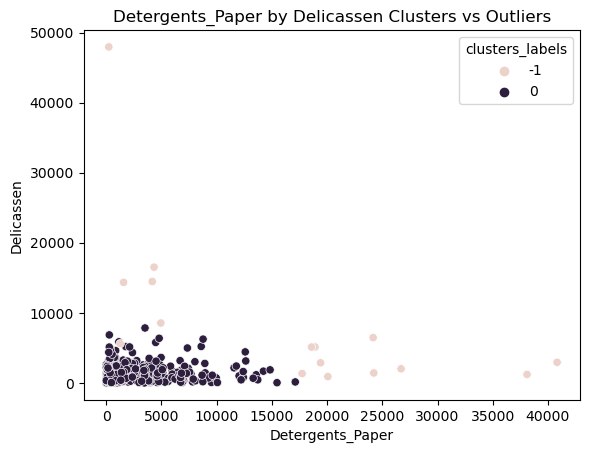

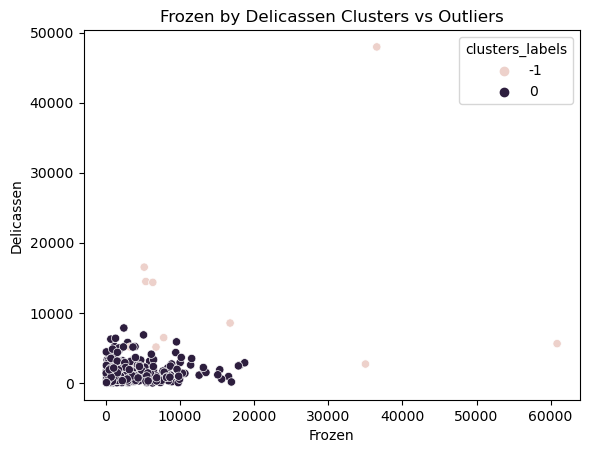

In [14]:
#A for loop to visualize de different clsuters combination and anomalies utilizing only 2 features at a time
for combination in itertools.combinations(x.columns,2):
    sns.scatterplot(df[combination[0]],df[combination[1]],hue=df.clusters_labels)
    plt.title(f"{combination[0]} by {combination[1]} Clusters vs Outliers")
    plt.show()

# Curriculum Logs Database:

In [73]:
#function to acquire data
from sqlalchemy import text, create_engine
def get_logs():
   
    url=env.get_db_url('logs')
    conn=create_engine(url).connect()
    query=text('select * from api_access')
    df=pd.read_sql(query,conn)
    return df

In [74]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [87]:
#acquiring data
df=get_logs()

In [88]:
df=df.entry.apply(parse_log_entry)

In [89]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


## Step 1: Select variables you want to cluster

In [91]:
x=df[['status_code','size']]
x.head()

,status_code,size
0,200,512495
1,200,3561
2,200,510103
3,200,510003
4,200,511963


In [105]:
df.index.isnull().sum()

0

In [99]:
df=df.dropna()

## Step 2: Convert to array & dtype float

In [100]:
#converting features into floats and arrays
np_array = x.values.astype('float32',copy=False)

## Step 3: Scale to standard normal

In [101]:
# MAKE the scaler
mms=MinMaxScaler()
# FIT/transform the scaler
x_scaled=mms.fit_transform(np_array)

x_scaled

array([[0.        , 0.9975844 ],
       [0.        , 0.00693158],
       [0.        , 0.9929283 ],
       ...,
       [0.        , 0.99619454],
       [0.        , 0.9929925 ],
       [0.        , 0.99305093]], dtype=float32)

In [102]:
# adding scaled data into the original datagrame
scaled_columns = ["Scaled_"+ column for column in x.columns]

In [103]:
# creating a copy of the original data frame
original_df = df.copy()

In [96]:
scaled_df = pd.DataFrame(x_scaled,columns=scaled_columns)

In [97]:
#merge scale data and dropping Key_0
df = df.merge(scaled_df,on=df.index)
df = df.drop(columns=['key_0'])

ValueError: Unable to fill values because RangeIndex cannot contain NA

df.head()

## Step 4: Create DBSCAN and fit

# Make the object
dbsc = DBSCAN(eps=1,min_samples=10)

# Fit the object
dbsc.fit(x_scaled)

## Step 5: Add labels back to original dataframe

# Assign the cluster labels
df['clusters_labels'] = dbsc.labels_

#A for loop to visualize de different clsuters combination and anomalies utilizing only 2 features at a time
for combination in itertools.combinations(x.columns,2):
    sns.scatterplot(df[combination[0]],df[combination[1]],hue=df.clusters_labels)
    plt.title(f"{combination[0]} by {combination[1]} Clusters vs Outliers")
    plt.show()

# Zillow database:
- Detect anomalies in number of bedrooms and finished square feet of property 

In [28]:
url=env.get_db_url('zillow')
    
query= """SELECT *
            from properties_2017 prop
        JOIN ( SELECT parcelid, MAX(transactiondate) AS max_transactiondate
                FROM predictions_2017
                GROUP BY parcelid) trans using (parcelid)
       
        JOIN predictions_2017 pred ON trans.parcelid = pred.parcelid
                          AND trans.max_transactiondate = pred.transactiondate
        
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
    
        WHERE land.propertylandusetypeid in (261,279)
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
       """
directory='/Users/chellyannmoreno/codeup-data-science/anomaly-detection-exercises/'
filename=('zillow.csv')
def get_data():
    if os.path.exists(directory+filename):
        df=pd.read_csv(filename)
        df = df[df['transactiondate'].str.startswith("2017", na=False)]
        return df
    else:
        df=pd.read_sql(query,url)
        df.to_csv(filename,index=False)
        # cache data locally
        df.to_csv(filename, index=False)
        df = df[df['transactiondate'].str.startswith("2017", na=False)]
        return df
    

In [29]:
df=get_data()

In [30]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,parcelid.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,14297519,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,17052889,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,...,14186244,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,...,12177905,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12095076,781532,NaN,...,12095076,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [31]:
df=df.fillna(0)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 71 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        52319 non-null  float64
 1   storytypeid                   52319 non-null  float64
 2   propertylandusetypeid         52319 non-null  float64
 3   heatingorsystemtypeid         52319 non-null  float64
 4   buildingclasstypeid           52319 non-null  float64
 5   architecturalstyletypeid      52319 non-null  float64
 6   airconditioningtypeid         52319 non-null  float64
 7   parcelid                      52319 non-null  int64  
 8   id                            52319 non-null  int64  
 9   basementsqft                  52319 non-null  float64
 10  bathroomcnt                   52319 non-null  float64
 11  bedroomcnt                    52319 non-null  float64
 12  buildingqualitytypeid         52319 non-null  float64
 13  c

## Step 1: Select variables you want to cluster

In [33]:
x=df[['bedroomcnt','calculatedfinishedsquarefeet']]
x.head()

,bedroomcnt,calculatedfinishedsquarefeet
0,4.0,3100.0
1,2.0,1465.0
2,3.0,1243.0
3,4.0,2376.0
4,4.0,2962.0


## Step 2: Convert features into array and float dtype

In [34]:
#converting features into floats and arrays
np_array = x.values.astype('float32',copy=False)

## Step 3: MinMax Scaler

In [35]:
# MAKE the scaler
mms=MinMaxScaler()
# FIT/transform the scaler
x_scaled=mms.fit_transform(np_array)

x_scaled

array([[0.2857143 , 0.14136532],
       [0.14285715, 0.06680651],
       [0.21428573, 0.05668293],
       ...,
       [0.2857143 , 0.07350996],
       [0.21428573, 0.04706097],
       [0.21428573, 0.08035022]], dtype=float32)

In [36]:
# adding scaled data into the original data frame
scaled_columns = ["Scaled_"+ column for column in x.columns]

In [37]:
# creating a copy of the original data frame
original_df = df.copy()

In [38]:
#creating dataframe of scaled data
scaled_df = pd.DataFrame(x_scaled,columns=scaled_columns)

In [39]:
#merge scale data and dropping Key_0
df = df.merge(scaled_df,on=df.index)
df = df.drop(columns=['key_0'])

In [40]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,Scaled_bedroomcnt,Scaled_calculatedfinishedsquarefeet
0,0.0,0.0,261.0,0.0,0.0,0.0,0.0,14297519,1727539,0.0,...,2017-01-01,0,0,0.0,0,Single Family Residential,0,0,0.285714,0.141365
1,0.0,0.0,261.0,0.0,0.0,0.0,0.0,17052889,1387261,0.0,...,2017-01-01,0,0,0.0,0,Single Family Residential,0,0,0.142857,0.066807
2,0.0,0.0,261.0,0.0,0.0,0.0,0.0,14186244,11677,0.0,...,2017-01-01,0,0,0.0,0,Single Family Residential,0,0,0.214286,0.056683
3,0.0,0.0,261.0,2.0,0.0,0.0,0.0,12177905,2288172,0.0,...,2017-01-01,0,0,0.0,Central,Single Family Residential,0,0,0.285714,0.108350
4,0.0,0.0,261.0,2.0,0.0,0.0,1.0,12095076,781532,0.0,...,2017-01-01,Central,0,0.0,Central,Single Family Residential,0,0,0.285714,0.135072


In [57]:
df=df[:5000]

In [58]:
x_scaled=x_scaled[:5000]

## Step 4: DBSCAN

In [59]:
# Make the object
dbsc = DBSCAN(eps=1,min_samples=20)

# Fit the object
dbsc.fit(x_scaled)

DBSCAN(eps=1, min_samples=20)

## Step 5: Add labels back to original dataframe

In [60]:
# Assign the cluster labels
df['clusters_labels'] = dbsc.labels_

In [63]:
dbsc.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Step 6: Explore and Viz Clusters

In [61]:
df.clusters_labels.value_counts()

0    100
Name: clusters_labels, dtype: int64

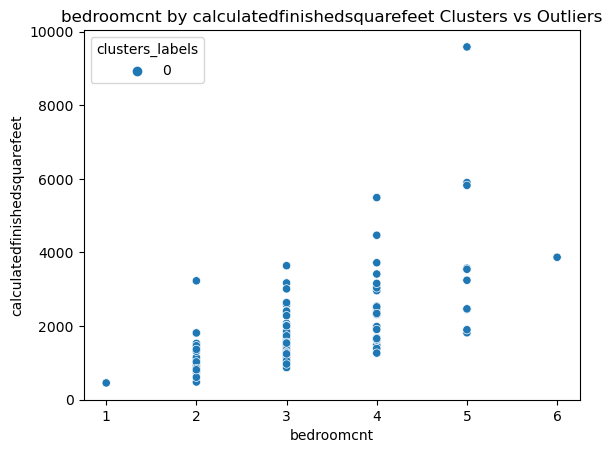

In [62]:
#A for loop to visualize de different clsuters combination and anomalies utilizing only 2 features at a time
for combination in itertools.combinations(x.columns,2):
    sns.scatterplot(df[combination[0]],df[combination[1]],hue=df.clusters_labels)
    plt.title(f"{combination[0]} by {combination[1]} Clusters vs Outliers")
    plt.show()